<a href="https://colab.research.google.com/github/ScoomenstheMumens/QiskitThesis-LGTQuantumSimulations/blob/main/VQEGEMreset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install retworkx
!pip install Qiskit
!pip install qiskit_nature
!pip install qiskit_ignis
!pip install qiskit-ibm-runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np

from time import time
from qiskit.providers.aer import QasmSimulator, Aer
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator,
                                Sampler as RuntimeSampler)

from qiskit import Aer

from qiskit.algorithms.optimizers import SPSA,COBYLA,L_BFGS_B,SLSQP

import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

from qiskit.primitives import Estimator,Sampler,BackendSampler,BackendEstimator
import retworkx as rx

from qiskit_nature.problems.second_quantization.lattice import Lattice

# Custom Heisenberg couplings
from qiskit.algorithms import NumPyEigensolver

from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter,ParameterVector

from qiskit import IBMQ

from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.circuit import Gate, Instruction, Parameter,ParameterVector

from util import GEM_calibration_circuits,qiskit_calibration_circuits,occurrences_to_vector,bin_list,occurrences_to_vector_decimal,DecimalToBinary

from qiskit.algorithms import MinimumEigensolver, VQEResult
from qiskit.result import marginal_counts

from qiskit.opflow import X, Z, I,Y


In [ ]:
# Get fake backend if you like
from qiskit.providers.fake_provider import FakeManila

# Noisy simulator backend
device_backend = FakeManila()
#noise_model = NoiseModel.from_backend(device_backend)
#IBMQ.disable_account()
#provider = IBMQ.enable_account('c0df7c866f628346a4ad9eb0955b0b9e8ffedc7dc25fa33a87a59e50864c059fa00f211c7f611efee085a4b810646179209cc819b26a4903c733466bb8b96f51')
IBMQ.update_account()
print(IBMQ.providers())


provider = IBMQ.get_provider(hub='ibm-q',
                            group='open', 
                            project='main')
backend_sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_manila'))
backend_real_jakarta = provider.get_backend('ibmq_manila')
backend_sim_ideal = Aer.get_backend('aer_simulator')
BACKEND = backend_sim_noisy_jakarta

Found 0 credentials.
No credentials available for updating could be found. No action will be performed.
[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>, <AccountProvider for IBMQ(hub='qc-fall-22-8', group='group-2', project='recrQvTQ0hTCoLumW')>]


In [ ]:
z=np.matrix([[1,0],[0,-1]])
z3=np.kron(z,np.kron(z,z))
print(z3)

[[ 1  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0]
 [ 0  0 -1  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0]
 [ 0  0  0  0 -1  0  0  0]
 [ 0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0 -1]]


In [ ]:
def Hamiltonian_heisenberg(g,h):
  X1 = X^X^X^I^I
  X2 = I^I^X^X^X
  Z0 = Z^I^I^I^I
  Z1 = I^Z^I^I^I
  Z2 = I^I^Z^I^I
  Z3 = I^I^I^Z^I
  Z4 = I^I^I^I^Z

  H=(h*X1) + \
    (h*X2) + \
    (g*Z0) + \
    (g*Z1) + \
    (g*Z2) + \
    (g*Z3) + \
    (g*Z4)
  return H

In [ ]:
ham=Hamiltonian_heisenberg(1,1)

In [ ]:
edge_list=[[0],[1],[2],[3],[4],[0,1,2],[2,3,4]]
comp_edge_list=[[1,2,3,4],[0,2,3,4],[0,1,3,4],[0,1,2,3],[3,4],[0,1]]

In [ ]:
# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=32)
exact_result = exact_solver.compute_eigenvalues(ham)
print(exact_result.eigenvalues)


# Save ground state energy for later
gs_energy = np.round(exact_result.eigenvalues[0], 4)

[-5.32849588 -3.78276476 -3.60555128 -3.60555128 -3.60555128 -3.60555128
 -2.23606798 -2.23606798 -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -0.54573112  0.54573112  1.
  1.          1.          1.          1.          1.          1.
  2.23606798  2.23606798  3.60555128  3.60555128  3.60555128  3.60555128
  3.78276476  5.32849588]


In [ ]:
def ham_ans_gen(num_qubits,depth):
  theta = ParameterVector("t",depth*7)
  qr=QuantumRegister(num_qubits)
  circuit = QuantumCircuit(qr)
  index = 0

  for _ in range (0,depth): 

    circuit.cx(qr[1],qr[2])
    circuit.cx(qr[3],qr[2])
    circuit.cx(qr[0],qr[1])
    circuit.cx(qr[4],qr[3])

    circuit.rx(theta[index],qr[0])
    index+=1
    circuit.rx(theta[index],qr[4])
    index+=1

    circuit.cx(qr[4],qr[3])
    circuit.cx(qr[0],qr[1])
    circuit.cx(qr[3],qr[2])
    circuit.cx(qr[1],qr[2])
  
    
    for i in range (0,5):
      circuit.h(qr[i])
      circuit.rz(theta[index],qr[i])
      index+=1
    
  return circuit


In [ ]:
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.circuit import Gate, Instruction, Parameter,ParameterVector


def pres_ans(depth,magne):
  qr_sym= QuantumRegister(5)
  qc_sym = QuantumCircuit(qr_sym)

  theta = ParameterVector("t",depth*12)
  index=0
  for i in range (0,magne):
    qc_sym.x(qr_sym[i])
  qc_sym.barrier()
  for i in range (0,depth):
    for j in range(0,2):
      qc_sym.h(qr_sym[j*2])
      qc_sym.rz(theta[index],qr_sym[j*2+1])
      index+=1
      qc_sym.cx(qr_sym[j*2],qr_sym[j*2+1])
      qc_sym.ry(theta[index],qr_sym[j*2])
      qc_sym.ry(theta[index],qr_sym[j*2+1])
      index+=1
      qc_sym.cx(qr_sym[j*2],qr_sym[j*2+1])
      qc_sym.h(qr_sym[j*2])
      qc_sym.rz(theta[index],qr_sym[j*2+1])
      index+=1
    qc_sym.barrier()
    for j in range(0,2):
      qc_sym.h(qr_sym[j*2+1])
      qc_sym.rz(theta[index],qr_sym[j*2+2])
      index+=1
      qc_sym.cx(qr_sym[j*2+1],qr_sym[j*2+2])
      qc_sym.ry(theta[index],qr_sym[j*2+1])
      qc_sym.ry(theta[index],qr_sym[j*2+2])
      index+=1
      qc_sym.cx(qr_sym[j*2+1],qr_sym[j*2+2])
      qc_sym.h(qr_sym[j*2+1])
      qc_sym.rz(theta[index],qr_sym[j*2+2])
      index+=1
  return qc_sym

In [ ]:
pres_ans(1,1).draw()

┌───┐ ░    ┌───┐         ┌──────────┐        ┌───┐     ░             »
q12726_0: ┤ X ├─░────┤ H ├──────■──┤ Ry(t[1]) ├──■─────┤ H ├─────░─────────────»
          └───┘ ░ ┌──┴───┴───┐┌─┴─┐├──────────┤┌─┴─┐┌──┴───┴───┐ ░    ┌───┐    »
q12726_1: ──────░─┤ Rz(t[0]) ├┤ X ├┤ Ry(t[1]) ├┤ X ├┤ Rz(t[2]) ├─░────┤ H ├────»
                ░ └──┬───┬───┘└───┘├──────────┤└───┘└──┬───┬───┘ ░ ┌──┴───┴───┐»
q12726_2: ──────░────┤ H ├──────■──┤ Ry(t[4]) ├──■─────┤ H ├─────░─┤ Rz(t[6]) ├»
                ░ ┌──┴───┴───┐┌─┴─┐├──────────┤┌─┴─┐┌──┴───┴───┐ ░ └──┬───┬───┘»
q12726_3: ──────░─┤ Rz(t[3]) ├┤ X ├┤ Ry(t[4]) ├┤ X ├┤ Rz(t[5]) ├─░────┤ H ├────»
                ░ └──────────┘└───┘└──────────┘└───┘└──────────┘ ░ ┌──┴───┴───┐»
q12726_4: ──────░────────────────────────────────────────────────░─┤ Rz(t[9]) ├»
                ░                                                ░ └──────────┘»
«                                              
«q12726_0: ────────────────────────────────────
«                ┌──────────┐         ┌───┐    
«q12726_1: ──■───┤ Ry(t[7]) ├──■──────┤ H ├────
«          ┌─┴─┐ ├──────────┤┌─┴─┐ ┌──┴───┴───┐
«q12726_2: ┤ X ├─┤ Ry(t[7]) ├┤ X ├─┤ Rz(t[8]) ├
«          └───┘┌┴──────────┤└───┘ └──┬───┬───┘
«q12726_3: ──■──┤ Ry(t[10]) ├──■──────┤ H ├────
«          ┌─┴─┐├───────────┤┌─┴─┐┌───┴───┴───┐
«q12726_4: ┤ X ├┤ Ry(t[10]) ├┤ X ├┤ Rz(t[11]) ├
«          └───┘└───────────┘└───┘└───────────┘

In [ ]:
def circs_to_run_to_mitigate(ansatz,edges):
  num_qubits=[]
  circs=[]
  qr_z=QuantumRegister(5)
  qc_z=QuantumCircuit(qr_z)

  qc_z.append(ansatz,qr_z)
  qc_z.measure_all()

  qr_x=QuantumRegister(5)
  qc_x=QuantumCircuit(qr_x)

  qc_x.append(ansatz,qr_x)
  qc_x.h(qr_x[i] for i in range (0,5))
  qc_x.measure_all()

  circs.append(qc_z)
  circs.append(qc_x)
  num_qubits.append(qc_z.num_qubits)
  num_qubits.append(qc_x.num_qubits)
  #qc_z.remove_final_measurements()

  #qc_z=transpile(qc_z,backend,optimization_level=0)

  for vert in edge_list:
    cal_circ_qiskit,s_labels=qiskit_calibration_circuits(5,vert)
    cal_circ_GEM,s_labels=GEM_calibration_circuits(ansatz,vert)
    #transpile(cal_circ_GEM[0][0],backend,optimization_level=0).counts_ops()
    #transpile(cal_circ_GEM[0][0],backend,optimization_level=0).counts_ops()
    circs+=cal_circ_qiskit
    circs+=cal_circ_GEM[0]
    circs+=cal_circ_GEM[1]
    for i in range (0,3*(2**len(vert))):
      num_qubits.append(len(vert))
  
  #print(len(circs))
  return circs,s_labels,num_qubits

In [ ]:
def circs_to_run(ansatz):
  num_qubits=[]
  circs=[]
  qr_z=QuantumRegister(5)
  qc_z=QuantumCircuit(qr_z)

  qc_z.append(ansatz,qr_z)
  qc_z.measure_all()

  qr_x=QuantumRegister(5)
  qc_x=QuantumCircuit(qr_x)

  qc_x.append(ansatz,qr_x)
  qc_x.h(qr_x[i] for i in range (0,5))
  qc_x.measure_all()

  circs.append(qc_z)
  circs.append(qc_x)

  num_qubits.append(qc_z.num_qubits)
  num_qubits.append(qc_x.num_qubits)

  return circs,num_qubits

In [ ]:
spsa = SPSA(maxiter=100,blocking=False, allowed_increase=1, trust_region=False,
                 learning_rate=None, perturbation=None, last_avg=10, resamplings=10,
                 perturbation_dims=None, second_order=False, regularization=None, 
                 hessian_delay=0, lse_solver=None, initial_hessian=None, callback=None,
                 termination_checker=None)

cobyla=COBYLA(maxiter=100, disp=True, rhobeg=3.0, tol=1e-2, options=None)
slsqp=SLSQP(maxiter=100, disp=False, ftol=1e-06, tol=None, eps=1.4901161193847656e-08, options=None, max_evals_grouped=1)

In [ ]:
from qiskit.utils.mitigation.fitters import CompleteMeasFitter
import copy
def meas_fitters(counts,edge,num):
  vec=[0,6,12,18,24,30,54]
  backend=Aer.get_backend('aer_simulator')
  meas_calibs, s_labels = qiskit_calibration_circuits(5,qubits_measure=edge)
  job_cal_aux = execute(meas_calibs, backend)
  cal_results_aux = job_cal_aux.result()
  cal_counts_aux=cal_results_aux.get_counts()
  meas_fitter_aux = CompleteMeasFitter(cal_results_aux, s_labels)
  job_qiskit=copy.deepcopy(cal_results_aux)
  for i in range (0,len(s_labels)):
    job_qiskit.results[i].data.counts=counts[2+vec[num]+i]
  meas_fitter = CompleteMeasFitter(job_qiskit, s_labels)
  job_GEM_L=copy.deepcopy(cal_results_aux)
  job_GEM_R=copy.deepcopy(cal_results_aux)
  for i in range (0,len(s_labels)):
    job_GEM_L.results[i].data.counts=meas_fitter.filter.apply(counts[2+vec[num]+len(s_labels)+i],method="least_squares")
    job_GEM_R.results[i].data.counts=meas_fitter.filter.apply(counts[2+vec[num]+2*len(s_labels)+i],method="least_squares")
  meas_fitter_GEM_L = CompleteMeasFitter(job_GEM_L, state_labels=s_labels)
  meas_fitter_GEM_R = CompleteMeasFitter(job_GEM_R, state_labels=s_labels)
  Cal_GEM_L = meas_fitter_GEM_L.cal_matrix
  Cal_GEM_R = meas_fitter_GEM_R.cal_matrix
  C=(Cal_GEM_L+Cal_GEM_R)/2
  rand_vec_prob=np.sum(C,axis=1,dtype='float')/(len(s_labels))
  p_t=(C[0][0]-1)/(rand_vec_prob[0]-1)
  rand_vec=p_t*shots*rand_vec_prob

  D=np.zeros((len(s_labels),len(s_labels)))

  for k in range (0,len(s_labels)):
      for j in range (0,len(s_labels)):
          D[k][j]=(C[k][j]-p_t*rand_vec_prob[k])/(1-p_t)
    
    
  meas_fitter_GP=copy.deepcopy(meas_fitter_aux)
  meas_fitter_GP.cal_matrices=D
  meas_fitter_GEM=copy.deepcopy(meas_fitter_aux)
  meas_fitter_GEM.cal_matrices=C
  plt.figure(figsize=(8,8))
  plt.subplot(211)
  plt.imshow(C)
  plt.colorbar()
  plt.subplot(212)
  plt.imshow(D)
  plt.colorbar()

  return meas_fitter,meas_fitter_GEM,meas_fitter_GP,p_t,rand_vec,s_labels

In [ ]:
shots=10000
import collections
# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class GEMCustomVQE(MinimumEigensolver):
    
    def __init__(self, sampler, circuit, optimizer,time_start,meas_fitter_qiskit=None,meas_fitter_GEM=None,meas_fitter_GP=None,p=None,rand=None, callback=None):
        self._sampler = sampler
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        self._meas_fitter_qiskit = meas_fitter_qiskit
        self._meas_fitter_GEM = meas_fitter_GEM
        self._meas_fitter_GP = meas_fitter_GP
        self._p=p
        self._rand=rand
        self._time_start=time
        
    def compute_minimum_eigenvalue(self):
                
        # Define objective function to classically minimize over
        def objective(x):
            qc_cal_bound=self._circuit.assign_parameters(x)
            energy=0
            energy_ideal=0
            if (self._meas_fitter_qiskit==None or (time()-self._time_start)>1500):
              print('calibration')
              
              qc_cal_bound=transpile(qc_cal_bound,BACKEND,optimization_level=0)
              qc_cal_bound.remove_final_measurements()
              circs,s_labels,num_qubits=circs_to_run_to_mitigate(qc_cal_bound,edge_list)
              #self._circuit=circs
              # Execute job with sampler primitive
              '''
              for i in range (0,len(circs)):
                print(transpile(circs[i],BACKEND,optimization_level=0).count_ops())
              '''
              job = self._sampler.run(circuits=circs,parameter_values=None, parameters=None,shots=10000)
              job_result=job.result().quasi_dists
              job_ideal=execute([circs[0],circs[1]],backend=Aer.get_backend('aer_simulator'),shots=10000)
              ideal_counts=job_ideal.result().get_counts()
              #print(job_result)
              # Get results from jobs
              
              new_dict=[]
              for i in range (0,len(job_result)):
                b=list(job_result[i].keys())
                for j in range (0,len(b)):
                  b[j]=DecimalToBinary(b[j],num_qubits[i])
                #print(b)
                a=list(job_result[i].values())
                labels=bin_list(int(np.log2(len(a))))
                new_dict.append(dict(zip(b,a)))
              self._meas_fitter_qiskit=[]
              self._meas_fitter_GEM=[]
              self._meas_fitter_GP=[]
              self._p=[]
              self._rand=[]
              for i,vert in enumerate(edge_list):
                m_q,m_g,m_p,p_t,rand_vec,s_labels=meas_fitters(new_dict,vert,i)
                self._meas_fitter_qiskit.append(m_q)
                self._meas_fitter_GEM.append(m_g)
                self._meas_fitter_GP.append(m_p)
                self._p.append(p_t)
                self._rand.append(rand_vec)
              self._time_start=time()
            else:
              circs,num_qubits=circs_to_run(qc_cal_bound)
              job = self._sampler.run(circuits=circs,parameter_values=None, parameters=None,shots=10000)
              job_result=job.result().quasi_dists
              job_ideal=execute([circs[0],circs[1]],backend=Aer.get_backend('aer_simulator'),shots=10000)
              ideal_counts=job_ideal.result().get_counts()
              # Get results from jobs
              new_dict=[]
              for i in range (0,len(job_result)):
                b=list(job_result[i].keys())
                for j in range (0,len(b)):
                  b[j]=DecimalToBinary(b[j],num_qubits[i])
                #print(b)
                a=list(job_result[i].values())
                labels=bin_list(int(np.log2(len(a))))
                new_dict.append(dict(zip(b,a)))
            print(self._p)
            print(self._rand)
            for j,vert in enumerate(edge_list):
              if (j<5):

                marginalised_counts = marginal_counts(new_dict[0], indices=vert)

                qiskit_counts=self._meas_fitter_qiskit[j].filter.apply(marginalised_counts,method="least_squares")
                
                print(qiskit_counts)
                raw_vector=occurrences_to_vector(marginalised_counts)
                print(raw_vector)
                print(self._rand[j])
                print(self._p[j])
                new_vector_CGP=(raw_vector-self._rand[j]/shots)/(1-self._p[j])
                new_counts=dict(zip(bin_list(1),new_vector_CGP))
                print(new_counts)
                new_counts_CGP=self._meas_fitter_GP[j].filter.apply(new_counts,method="least_squares")
              
                
                mitigated_counts=self._meas_fitter_GEM[j].filter.apply(qiskit_counts,method="least_squares")
                mitigated_vector=occurrences_to_vector(new_counts_CGP)
                energy_string=mitigated_vector[0]-mitigated_vector[1]
                energy+=energy_string
              else:
                marginalised_counts = marginal_counts(new_dict[1], indices=vert)
                qiskit_counts=self._meas_fitter_qiskit[j].filter.apply(marginalised_counts,method="least_squares")
                
                raw_vector=occurrences_to_vector(marginalised_counts)
                new_vector_CGP=(raw_vector-self._rand[j]/shots)/(1-self._p[j])
                new_counts=dict(zip(bin_list(3),new_vector_CGP))
                new_counts_CGP=self._meas_fitter_GP[j].filter.apply(new_counts,method="least_squares")
                

                mitigated_counts=self._meas_fitter_GEM[j].filter.apply(qiskit_counts,method="least_squares")
                mitigated_vector=occurrences_to_vector(new_counts_CGP)
                energy_string=mitigated_vector[0]-mitigated_vector[1]-mitigated_vector[2]+mitigated_vector[3]-mitigated_vector[4]+mitigated_vector[5]+mitigated_vector[6]-mitigated_vector[7]
                energy+=energy_string
            for j,vert in enumerate(edge_list):
              if (j<5):
                marginalised_counts= marginal_counts(ideal_counts[0], indices=vert)
                mitigated_vector=occurrences_to_vector(marginalised_counts)
                energy_string_ideal=mitigated_vector[0]-mitigated_vector[1]
                energy_ideal+=energy_string_ideal/shots
              else:
                marginalised_counts = marginal_counts(ideal_counts[1], indices=vert)
                mitigated_vector=occurrences_to_vector(marginalised_counts)
                energy_string_ideal=mitigated_vector[0]-mitigated_vector[1]-mitigated_vector[2]+mitigated_vector[3]-mitigated_vector[4]+mitigated_vector[5]+mitigated_vector[6]-mitigated_vector[7]
                energy_ideal+=energy_string_ideal/shots
            print('noisy_energy')
            print(energy)
            print('ideal_energy')
            print(energy_ideal)
            '''
            estimator = Estimator()
            job = estimator.run(circuits=qc_cal_bound, observables=[ham])
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            print(value)
            '''
            # Save result information using callback function
            if self._callback is not None:
                self._callback(energy)   
            return energy
            
        # Select an initial point for the ansatzs' parameters

        x0=np.ones(self._circuit.num_parameters)*np.pi/4
        #x0=np.random.rand(self._circuit.num_parameters)

        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [ ]:
# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)
# Setup VQE algorithm
custom_vqe = GEMCustomVQE(Sampler(), ham_ans_gen(5,2), cobyla,time(), meas_fitter_qiskit=None,meas_fitter_GEM=None, callback=callback)

# Run the custom VQE function and monitor execution time
start = time()
result = custom_vqe.compute_minimum_eigenvalue()
end = time()

print(result)
print(f'execution time (s): {end - start:.2f}')
plt.figure(figsize=(13,11))
plt.plot(intermediate_info, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

ValueError: ignored

In [ ]:
# Save an IBM Quantum account. See docs for credential security warning
# https://github.com/Qiskit/qiskit-ibm-runtime/tree/stable/0.7#saving-account-on-disk
QiskitRuntimeService.save_account(channel="ibm_quantum",overwrite=True, token='c0df7c866f628346a4ad9eb0955b0b9e8ffedc7dc25fa33a87a59e50864c059fa00f211c7f611efee085a4b810646179209cc819b26a4903c733466bb8b96f51')
service = QiskitRuntimeService(channel='ibm_quantum')

In [ ]:
# Define a simple callback function
intermediate_info_sim_backend = []
def callback_sim(value):
        intermediate_info_sim_backend.append(value)
        #print(value)

In [ ]:
backend='ibmq_manila'

calibration
[0.10683188513142104, 0.27221748992148365, 0.4547545962192765, 0.3231555925069252, 0.24019555656656377, 0.3492677466900645, 0.39597217758856995]
[array([532.58550751, 535.73334381]), array([1333.96006033, 1388.21483889]), array([2315.82555551, 2231.72040668]), array([1562.27370125, 1669.28222382]), array([1183.61455324, 1218.34101243]), array([433.21177795, 440.41132605, 447.28272476, 428.77414192,
       440.8634509 , 408.20880302, 447.54911899, 446.37612331]), array([528.25202081, 480.06359888, 489.85722633, 505.14729864,
       507.64257522, 471.37223452, 485.79634051, 491.59048098])]
{'0': 0.7737062036620304, '1': 0.22629379633796953}
[0.7657 0.2343]
[532.58550751 535.73334381]
0.10683188513142104
{'0': 0.797656608413622, '1': 0.20234339158637799}
{'0': 0.6603119575154424, '1': 0.33968804248455764}
[0.6856 0.3144]
[1333.96006033 1388.21483889]
0.27221748992148365
{'0': 0.7587486458114637, '1': 0.24125135418853647}
{'0': 0.6496774191714033, '1': 0.3503225808285967}
[0.65

/usr/local/lib/python3.8/dist-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


[0.10683188513142104, 0.27221748992148365, 0.4547545962192765, 0.3231555925069252, 0.24019555656656377, 0.3492677466900645, 0.39597217758856995]
[array([532.58550751, 535.73334381]), array([1333.96006033, 1388.21483889]), array([2315.82555551, 2231.72040668]), array([1562.27370125, 1669.28222382]), array([1183.61455324, 1218.34101243]), array([433.21177795, 440.41132605, 447.28272476, 428.77414192,
       440.8634509 , 408.20880302, 447.54911899, 446.37612331]), array([528.25202081, 480.06359888, 489.85722633, 505.14729864,
       507.64257522, 471.37223452, 485.79634051, 491.59048098])]
{'0': 0.2602592946294783, '1': 0.7397407053705217}
[0.2865 0.7135]
[532.58550751 535.73334381]
0.10683188513142104
{'0': 0.26113947124453535, '1': 0.7388605287554647}
{'0': 0.30456383512639396, '1': 0.695436164873606}
[0.3777 0.6223]
[1333.96006033 1388.21483889]
0.27221748992148365
{'0': 0.33568269446456683, '1': 0.6643173055354333}
{'0': 0.2737634365178732, '1': 0.7262365634821267}
[0.3075 0.6925]
[2

KeyboardInterrupt: ignored

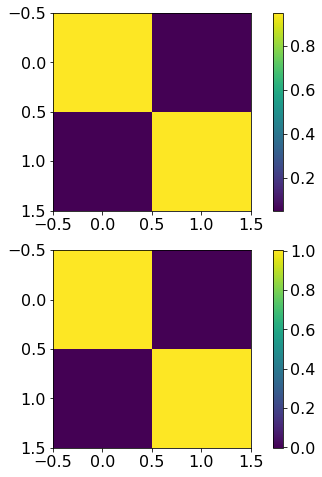

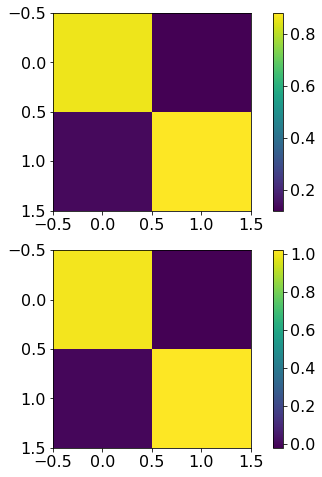

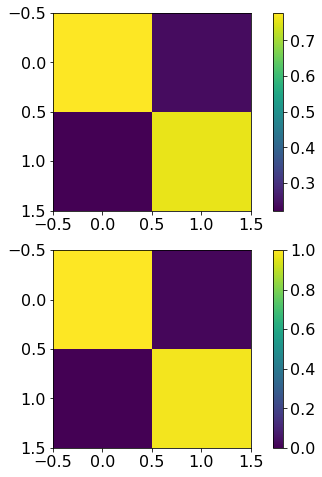

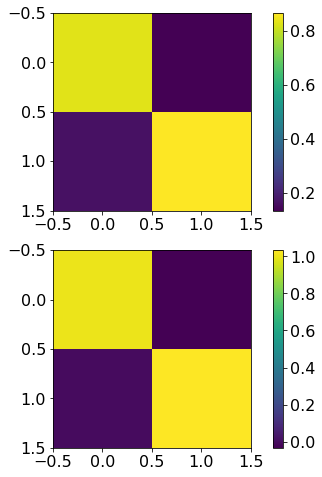

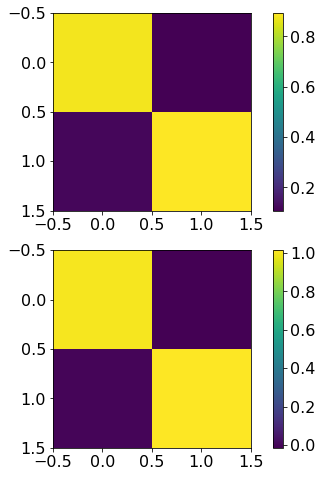

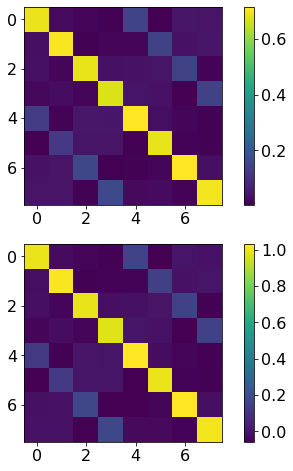

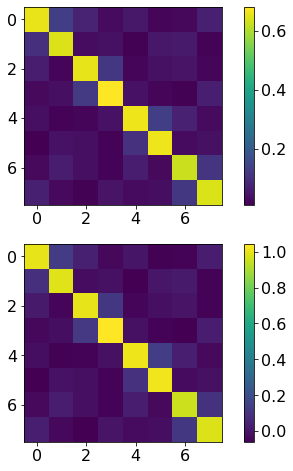

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options

# Setup Estimator
start = time()
options = Options()
options.optimization_level = 0
options.resilience_level = 0
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)
    # Set up algorithm
    custom_vqe = GEMCustomVQE(rt_estimator, ham_ans_gen(5,2), cobyla, time(),meas_fitter_qiskit=None,meas_fitter_GEM=None, callback=callback_sim)
    # Run algorithm
    result = custom_vqe.compute_minimum_eigenvalue()
end = time()
print(f'execution time (s): {end - start:.2f}')

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 100,
    'eigenstate': None,
    'eigenvalue': -5.2052817316435505,
    'optimal_circuit': None,
    'optimal_parameters': array([ 3.47669999,  3.44792244,  0.22855802, -0.20032617,  2.86015774,
       -0.04737853, -0.15380825,  5.07522236, -0.01031975,  0.99587999,
        0.97750106,  0.98290571,  1.34067135,  0.99076814]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): -9535.70


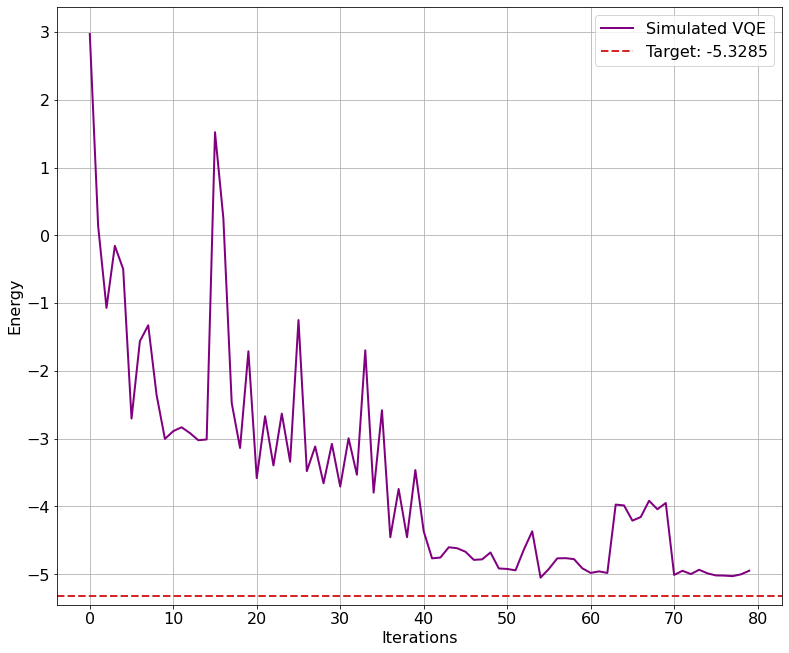

In [ ]:
print(result)
print(f'execution time (s): {end - start:.2f}')
plt.figure(figsize=(13,11))
plt.plot(intermediate_info_sim_backend, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()